In [1]:
!module load pytorch-gpu/py3/1.10.0

In [2]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
# Hyperparameters

length = 12
batch_size = 8
epochs = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# dataset qui contient les donnees, ie la fonction de courant barotrope
# chemin sur jean-zay : /gpfswork/rech/omr/romr004/MLspinup/IPSLCM6ALR/
MSFTdataset = xr.open_dataset('/gpfswork/idris/sos/ssos025/HRMES/MLspinup/IPSLCM6ALR/msftbarot_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_185001-234912.nc',decode_times=False)
MSFTdataset

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
  * time            (time) float64 15.5 45.0 74.5 ... 1.826e+05 1.826e+05
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    time_bounds     (time, axis_nbounds) float64 ...
    msftbarot       (time, y, x) float32 ...
Attributes: (12/51)
    name:                   /ccc/work/cont003/dsm/p86maf/IGCM_OUT/IPSLCM6/PRO...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-04-27T15:00:09Z
    tracking_id:            hdl:21.14100/17e4ba33-4948-4a89-b737-937464656d8d
    description:            DECK: control
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    ...                     ...
    variant_label:          r1i1p1f1
    EXPID:                  piControl
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          00e1a4f623b35a33620b9828c66bd1c8
    model_version:          6.1.2
    history:                Tue Jul 10 16:42:45 2018: ncatted -O -a coordinat...

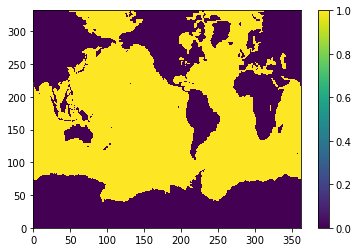

In [5]:
# dataset qui contient les informations "fixed in time" comme le masque terre / mer et la bathymetrie
MASKdataset = xr.open_dataset('/gpfswork/idris/sos/ssos025/HRMES/MLspinup/INPUTS/eORCA1.2_mesh_mask.nc',decode_times=False)
MASKdataset
mask = MASKdataset.tmask[0,0,:,:]
plt.pcolor(mask) ; plt.colorbar() 

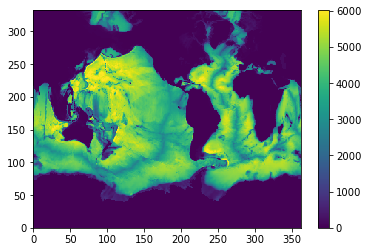

In [6]:
bathy = np.sum(MASKdataset.e3t_0[0,:,:,:]*MASKdataset.tmask[0,:,:],axis=0)
plt.pcolor(bathy)
plt.colorbar()

In [7]:
MSFTdataset.msftbarot.shape

(6000, 332, 362)

In [8]:
def get_ssca(dataset):
    dataset = np.array(dataset)
    x, y = dataset.shape[1:3]
    nbyears = dataset.shape[0] // 12
    arr = np.reshape(dataset, (nbyears, 12, x, y))
    arr = np.mean(arr, axis=0)
    arr = np.tile(arr, (nbyears, 1, 1, 1))
    arr = np.reshape(arr, (12 * nbyears, x, y))
    return dataset - arr

ssca = get_ssca(MSFTdataset.msftbarot)

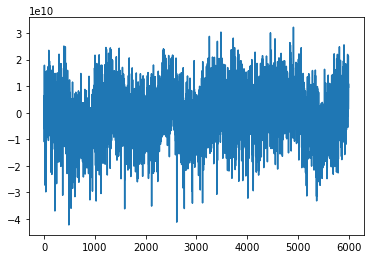

In [9]:
plt.plot(ssca[:, 110, 110])

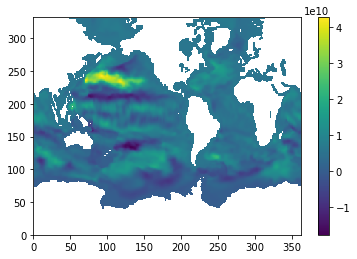

In [10]:
plt.pcolor(ssca[458])
plt.colorbar()

In [11]:
mask == 1.0

<xarray.DataArray 'tmask' (y: 332, x: 362)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: y, x

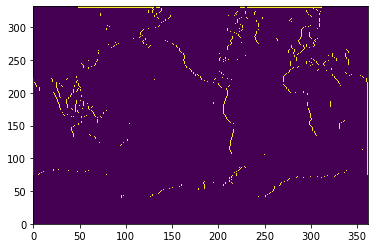

In [12]:
plt.pcolor(np.logical_and(mask == 1.0, ~np.isfinite(ssca[0])))

In [13]:
bool_mask = torch.tensor(np.asarray(np.isfinite(ssca[0])), dtype=bool).to(device=device)
mask = bool_mask.to(device=device, dtype=int)


/tmp/ipykernel_3139493/240239548.py:2: RuntimeWarning: All-NaN slice encountered
  M = np.nanmax(ssca, axis=0, keepdims=True)
/tmp/ipykernel_3139493/240239548.py:3: RuntimeWarning: All-NaN slice encountered
  m = np.nanmin(ssca, axis=0, keepdims=True)


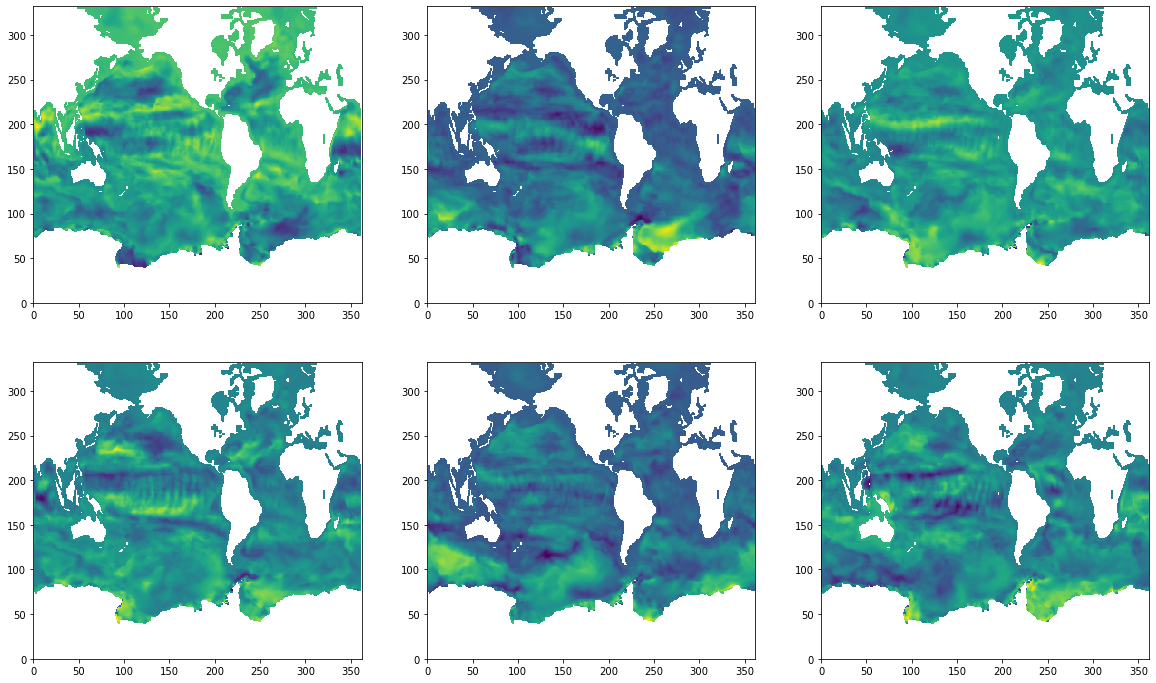

In [14]:
%matplotlib inline
M = np.nanmax(ssca, axis=0, keepdims=True)
m = np.nanmin(ssca, axis=0, keepdims=True)
norm_ssca = (ssca - m) / (M - m)

fig = plt.figure(figsize=(20,12))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.pcolor(norm_ssca[i * 1000])

In [15]:
maps = torch.from_numpy(norm_ssca)

In [16]:
data = []
for i in tqdm(range(maps.shape[0] - length)):
    data.append(torch.arange(i, i + length + 1))
data = torch.stack(data, axis=0)

  0%|          | 0/5988 [00:00<?, ?it/s]

In [17]:
torch.allclose(maps[data[0]][0], maps[0], equal_nan=True)

True

In [18]:
class HRMESDataset(Dataset):

    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return self.indices.shape[0]

    def __getitem__(self, idx):
        idx = self.indices[idx]
        return maps[idx[:-1]], maps[idx[-1]]

In [19]:
train_ds = HRMESDataset(data[:5000])
test_ds = HRMESDataset(data[5000:])
print(len(train_ds), len(test_ds))
print(train_ds[0][0].shape, train_ds[0][1].shape)

5000 988
torch.Size([12, 332, 362]) torch.Size([332, 362])


In [20]:
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True, prefetch_factor=2)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, num_workers=4, persistent_workers=True, prefetch_factor=2)

In [21]:
class Conv(nn.Module):

    def __init__(self, inp, out, mask):
        super(Conv, self).__init__()
        self.mask = mask[None, None, ...]
        self.conv = nn.Conv2d(inp, out, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv(x))
        #x = x * self.mask
        return x

class HRMESModel(nn.Module):

    def __init__(self, mask):
        super(HRMESModel, self).__init__()
        self.mask = mask
        self.layers = nn.Sequential(
            Conv(12, 32, mask=mask),
            Conv(32, 64, mask=mask),
            Conv(64, 128, mask=mask),
            Conv(128, 64, mask=mask),
            Conv(64, 32, mask=mask),
            Conv(32, 1, mask=mask)
            #nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = torch.nan_to_num(x)
        x = self.layers(x)
        x = x.squeeze(dim=1)
        return x
        

In [22]:
model = HRMESModel(mask)
model = model.to(device=device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

188064


In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [24]:
losses = []
test_losses = []

for epoch in range(epochs):
    print("Epoch ", epoch + 1)
    epoch_loss = 0.0
    pbar = tqdm(train_dataloader)
    for i, (x, y) in enumerate(pbar, start=1):
        x, y = x.to(device), y.to(device)
        output = model(x)
        output = torch.masked_select(output, bool_mask)
        y = torch.masked_select(y, bool_mask)

        optimizer.zero_grad()
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()

        loss = loss.item()
        epoch_loss += loss
        pbar.set_description(f"Loss: {epoch_loss / i:.3f}")
        del x, y
    
    pbar = tqdm(test_dataloader)
    test_loss = 0.0
    
    for i, (x, y) in enumerate(pbar, start=1):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            output = model(x)
            output = torch.masked_select(output, bool_mask)
            y = torch.masked_select(y, bool_mask)
            loss = criterion(output, y)
            loss = loss.item()
            test_loss += loss
            pbar.set_description(f"Test loss: {test_loss / i:.3f}")
    test_loss /= len(test_dataloader)
    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)
    test_losses.append(test_loss)
    print("Loss: ", epoch_loss)

Epoch  1


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Loss:  0.03290599561929703


In [25]:
del output

In [26]:
x, y = test_ds[100]
x = x.to(device)
output = model(x[None])[0].cpu()
output = output.detach().numpy()
y = y.detach().numpy()
output[np.isnan(y)] = np.nan

In [27]:
np.nanmean(y), np.nanstd(y)

(0.6210912, 0.0939007)

In [28]:
np.nanmean(output), np.nanstd(output)

(0.5213322, 0.08105316)

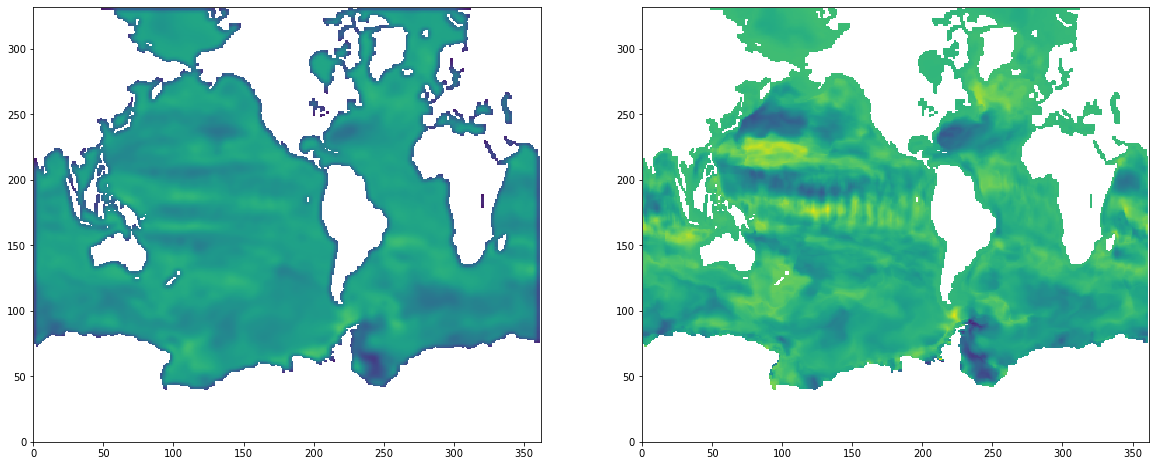

In [29]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.pcolor(output, vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.pcolor(y, vmin=0, vmax=1)
